In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# import gzip, json

# def parse(path):
#   with open(path, 'r') as g:
#     for l in g:
#         yield json.loads(l)

# meta_data = []

# for review in parse("meta_Software.json"):
#   meta_data.append(review)

In [23]:
import matplotlib.pyplot as plt
def plot(log_loss, log_val_loss, test_loss, title=''):
    plt.figure(figsize=(10, 6))
    epochs = len(log_loss)
    # Plot training and validation loss
    plt.plot(range(epochs), log_loss, label='Training Loss (MSE + reg)')
    plt.plot(range(epochs), log_val_loss, label='Validation Loss (MSE)')

    # Add a horizontal line for test loss
    # Add a horizontal line for test loss
    test_loss_label = f'Test Loss (MSE): {test_loss:.4f}'  # Format with 4 decimal places
    plt.axhline(y=test_loss, color='r', linestyle='--', label=test_loss_label)

    # Add labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()

    # Show the plot
    plt.show()

In [24]:
def model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# common data

In [25]:
import numpy as np
data = np.load("non-text-feature.npz")

In [26]:
userID=data['userID']
itemID=data['itemID']

num_user = np.max(userID)+1
num_item = np.max(itemID)+1

In [27]:
list(data.keys())

['indices_train',
 'indices_val',
 'indices_test',
 'userID',
 'userID_onehot',
 'itemID',
 'itemID_onehot',
 'verified',
 'review_length',
 'rating',
 'days',
 'weekdays',
 'month',
 'vote']

In [29]:
has_vote = data['vote']>0

userID = data['userID'][has_vote]
itemID = data['itemID'][has_vote]
day    = data['days'][has_vote]
weekdays = data['weekdays'][has_vote]
month    = data['month'][has_vote]
verified = data['verified'][has_vote]
review_length = data['review_length'][has_vote]
rating = data['rating'][has_vote]

vote = np.log10(data['vote'][has_vote])

from sklearn.model_selection import train_test_split
indices = np.arange(len(vote))
indices_train, indices_test = train_test_split(indices, test_size=0.1, random_state=42)
indices_train, indices_val = train_test_split(indices_train, test_size=0.1/0.9, random_state=42)

# Model

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class text_MLP(nn.Module):
    def __init__(self, num_user, num_item, embedding_dim=50, text_feature_dim = 300, hidden_dim=20, output_dim = 1, lambda_reg = 0.01):
        super(text_MLP, self).__init__()
        self.lambda_reg = lambda_reg

        # Assuming user_id and item_id are categorical variables that will be represented using embeddings
        self.user_embedding = nn.Embedding(num_embeddings=num_user, embedding_dim=embedding_dim)
        self.item_embedding = nn.Embedding(num_embeddings=num_item, embedding_dim=embedding_dim)

        # The input dimension will be the sum of the dimensions of the embeddings and the text features
        input_dim = 2 * embedding_dim + 5 + text_feature_dim

        # Defining the MLP layers
        self.fc1 = nn.Linear(input_dim, hidden_dim, dtype=torch.float)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, dtype=torch.float)
        self.fc3 = nn.Linear(hidden_dim, output_dim, dtype=torch.float)
        
        self.dev_a = nn.Parameter(torch.randn(1))
        self.dev_b = nn.Parameter(torch.randn(1))

        self.to(device)

    def forward(self, user_id, item_id, day, weekday, month, verified, review_length, text_features):
        user_embedded = self.user_embedding(user_id)
        item_embedded = self.item_embedding(item_id)
        day_dev = self.dev_a * torch.exp(-self.dev_b * day)
        # Concatenate user, item embeddings and text features
        concatenated_features = torch.cat((user_embedded, item_embedded, day_dev.unsqueeze(1), 
                                           weekday.unsqueeze(1), month.unsqueeze(1), verified.unsqueeze(1), review_length.unsqueeze(1),
                                           text_features), dim=1)
        x = F.relu(self.fc1(concatenated_features))
        x = F.relu(self.fc2(x))
        output = self.fc3(x).squeeze()
        return output

    def fit(self, train, val,  lr = 0.001,  num_epochs=3000, patience = 5):
        userID_train = torch.tensor(train[0], device=device)
        itemID_train = torch.tensor(train[1], device=device)
        day_train    = torch.tensor(train[2], device=device)
        weekdays_train = torch.tensor(train[3], device=device)
        month_train    = torch.tensor(train[4], device=device)
        verified_train = torch.tensor(train[5], device=device)
        review_length_train = torch.tensor(train[6], device=device)
        text_train = torch.tensor(train[7], device=device, dtype=torch.float)
        y_train  = torch.tensor(train[-1], device=device, dtype=torch.float)

        userID_val = torch.tensor(val[0], device=device)
        itemID_val = torch.tensor(val[1], device=device)
        day_val    = torch.tensor(val[2], device=device)
        weekdays_val = torch.tensor(val[3], device=device)
        month_val    = torch.tensor(val[4], device=device)
        verified_val = torch.tensor(val[5], device=device)
        review_length_val = torch.tensor(val[6], device=device)
        text_val = torch.tensor(val[7], device=device, dtype=torch.float)
        y_val  = torch.tensor(val[-1], device=device, dtype=torch.float)

        # early stop
        best_val_loss = float('inf')
        epochs_no_improve = 0

        # log
        self.log_loss = []
        self.log_val_loss = []

        # train prep
        optimizer = optim.Adam(self.parameters(),  lr=lr)
        criterion = nn.MSELoss()

        # train loop
        bar = tqdm(range(num_epochs))
        for epoch in bar:
            optimizer.zero_grad()
            predictions = self.forward(userID_train, itemID_train, day_train, weekdays_train, month_train, verified_train, review_length_train, text_train)
            # Compute loss
            loss = criterion(predictions,  y_train)
            l2_reg = torch.tensor(0., device=device)
            for param in self.parameters():
                l2_reg += param.norm(2)
            loss += self.lambda_reg * l2_reg
            self.log_loss.append(loss.item())
            # backworks
            loss.backward()
            optimizer.step()
            # Early stopping check
            with torch.no_grad():
                val_preds = self.forward(userID_val, itemID_val, day_val, weekdays_val, month_val, verified_val, review_length_val, text_val) # ignore cold start
                val_loss = criterion(val_preds,  y_val)
                self.log_val_loss.append(val_loss.item())
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs')
                    break
            bar.set_postfix({"Epoch":epoch,  "loss": loss.item(),  "val_Loss": val_loss.item()})
        
        return best_val_loss

### Word 2 Vec

In [31]:
word2vec = np.load("text-feature_word2vec.npz")['word2vec'][has_vote]

In [85]:
# Create the model instance
best_w2v_model = None
best_lambda = None
best_val_loss = float("inf")

D =  [userID, itemID, day, weekdays, month, verified, review_length, word2vec, vote]
for lambda_reg in [0.00015848931924611142]: #np.logspace(-5,1,6):
    for hidden_dim in [10]:#np.logspace(1,2,4):
        for embedding_dim in [1]: #np.logspace(0,2,5):
            hidden_dim, embedding_dim = int(hidden_dim), int(embedding_dim)
            
            w2v_model = text_MLP(num_user, num_item, hidden_dim=hidden_dim, embedding_dim=embedding_dim, lambda_reg=lambda_reg)
            val_loss = w2v_model.fit(
                [f[indices_train] for f in D], 
                [f[indices_val] for f in D], 
                lr =0.001, num_epochs=1000
            )
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_w2v_model = w2v_model
                best_lambda = (lambda_reg, hidden_dim, embedding_dim)
print(best_lambda)

  6%|▌         | 55/1000 [00:00<00:03, 271.15it/s, Epoch=54, loss=0.28, val_Loss=0.168] 

Early stopping triggered after 56 epochs
(0.00015848931924611142, 10, 1)


0.15188349950113655


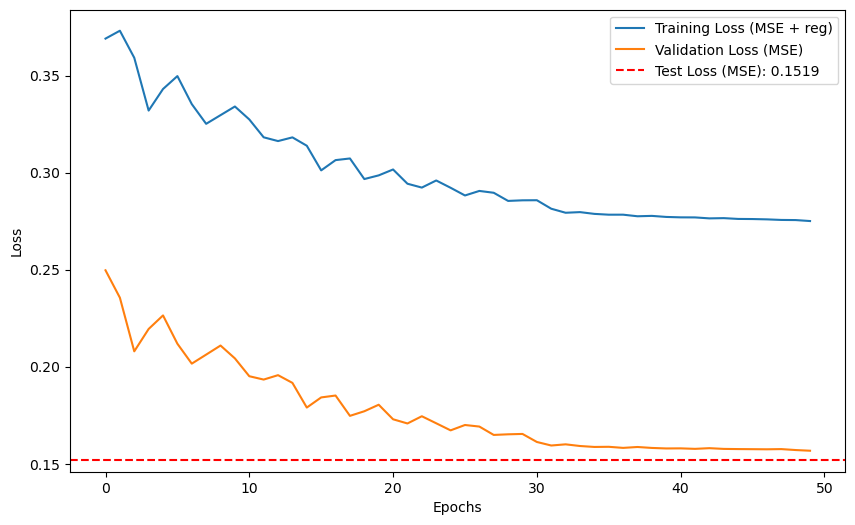

In [87]:
prediction_test = best_w2v_model.forward(
    torch.tensor(userID[indices_test], device=device),
    torch.tensor(itemID[indices_test], device=device),
    torch.tensor(day[indices_test], device=device, dtype=torch.float),
    torch.tensor(weekdays[indices_test], device=device, dtype=torch.float),
    torch.tensor(month[indices_test], device=device, dtype=torch.float),
    torch.tensor(verified[indices_test], device=device, dtype=torch.float),
    torch.tensor(review_length[indices_test], device=device, dtype=torch.float),
    torch.tensor(word2vec[indices_test], device=device, dtype=torch.float)
).cpu().detach().numpy()
test_loss = mean_squared_error(vote[indices_test], prediction_test)
print(test_loss)
plot(best_w2v_model.log_loss[:50], best_w2v_model.log_val_loss[:50], test_loss)

In [88]:
print(model_size(best_w2v_model))
torch.save(best_w2v_model, "best_w2v_model.ckpt")

400013


### tfidf

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
import gzip, json
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield json.loads(l)

data = []
for review in parse("Software.json.gz"):
    data.append(review)

documents_raw = []
for d in data: 
    strs = []
    if 'summary' in d:
        strs.append(d['summary'])
    if 'reviewText' in d:
        strs.append(d['reviewText'])
    documents_raw.append(" ".join(strs))

In [90]:
documents = [] # get has vote documents
for d, b in zip(documents_raw, has_vote):
    if b:
        documents.append(d)
len(documents)

127853

In [91]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=300)
tfidf_vectorizer.fit( [documents[i] for i in indices_train])
tfidf = tfidf_vectorizer.transform(documents).toarray()

In [163]:
# Create the model instance
best_tfidf_model = None
best_lambda = None
best_val_loss = float("inf")

D =  [userID, itemID, day, weekdays, month, verified, review_length, word2vec, vote]
for lambda_reg in [0.0001]: #np.logspace(-5,1,6):
    for hidden_dim in [21]: #np.logspace(1,2,4):
        for embedding_dim in [10]: # np.logspace(0,2,5):
            hidden_dim, embedding_dim = int(hidden_dim), int(embedding_dim)
            
            tfidf_model = text_MLP(num_user, num_item, hidden_dim=hidden_dim, embedding_dim=embedding_dim, lambda_reg=lambda_reg)
            val_loss = tfidf_model.fit(
                [f[indices_train] for f in D], 
                [f[indices_val] for f in D], 
                lr =0.001, num_epochs=1000,
                patience=20
            )
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_tfidf_model = tfidf_model
                best_lambda = (lambda_reg, hidden_dim, embedding_dim)
print(best_lambda)

 16%|█▌        | 156/1000 [00:00<00:04, 183.07it/s, Epoch=155, loss=0.367, val_Loss=0.165]

Early stopping triggered after 157 epochs
(0.0001, 21, 10)


0.22096490702733368


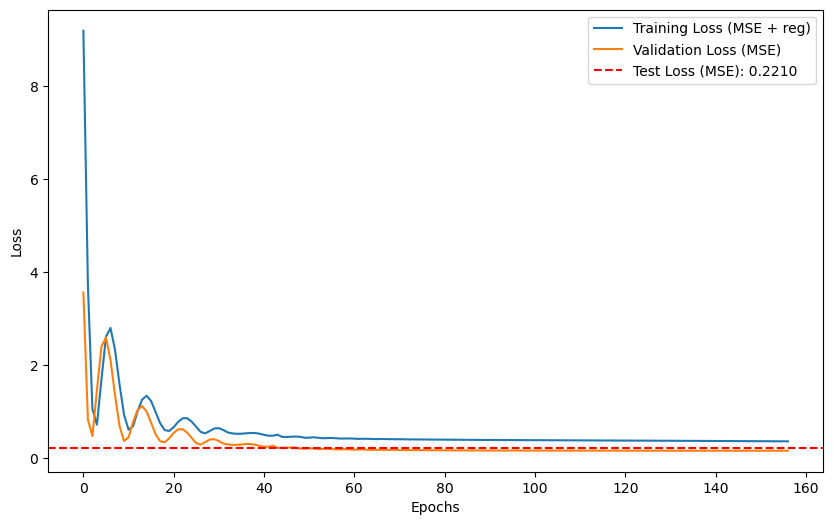

In [164]:
prediction_test = best_tfidf_model.forward(
    torch.tensor(userID[indices_test], device=device),
    torch.tensor(itemID[indices_test], device=device),
    torch.tensor(day[indices_test], device=device, dtype=torch.float),
    torch.tensor(weekdays[indices_test], device=device, dtype=torch.float),
    torch.tensor(month[indices_test], device=device, dtype=torch.float),
    torch.tensor(verified[indices_test], device=device, dtype=torch.float),
    torch.tensor(review_length[indices_test], device=device, dtype=torch.float),
    torch.tensor(tfidf[indices_test], device=device, dtype=torch.float)
).cpu().detach().numpy()
test_loss = mean_squared_error(vote[indices_test], prediction_test)
print(test_loss)
plot(best_tfidf_model.log_loss, best_tfidf_model.log_val_loss, test_loss)

In [135]:
print(model_size(best_tfidf_model))
torch.save(best_tfidf_model, "best_tfidf_model.ckpt")

119052183
